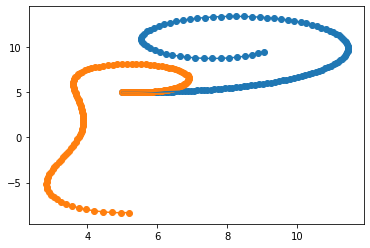

In [110]:
# https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/blob/master/vehicleModels_commonRoad.pdf
# https://github.com/pricejiang/RRT_planner/blob/master/model/Car_Kinematic/Car_Kinematic.py

import collections
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import math
import random

KinematicSingleTrackConfig = collections.namedtuple('KinematicSingleTrackConfig', 
                                                     'name steer_min steer_max v_steer_min '
                                                      'v_steer_max v_min v_max a_max switch_v')

kst_config_small_car = KinematicSingleTrackConfig(name='small_car', 
                                                    steer_min=-0.91, steer_max=0.91,
                                                    v_steer_min=-0.4, v_steer_max=0.4,
                                                    v_min=-13.9, v_max=45.8,
                                                    a_max=11.5, switch_v=4.755)

def control_vector(steer_vel=0.0, long_accel=0.0):
    return [float(x) for x in [steer_vel, long_accel]]

def state_vector(pos_x=0.0, pos_y=0.0, yaw=0.0, vel=0.0, steer_angle=0.0):
    return [float(x) for x in [pos_x, pos_y, yaw, vel, steer_angle]]

def state_vector_pos(state_vector):
    return state_vector[0:2]


def model_diff_eq_kinematic_single_track(Xn, u, config=kst_config_small_car):
    v = Xn[3]
    psi = Xn[2]
    sx_dot = v*np.cos(psi)
    sy_dot = v*np.sin(psi)
    psi_dot = np.clip(v, config.v_min, config.v_max)/2.578*np.tan(np.clip(Xn[4], config.steer_min, config.steer_max))
    return [sx_dot, sy_dot, psi_dot, u[1], u[0]]

def integ_state(Xn, u, dt=0.2, model_diff_eq=model_diff_eq_kinematic_single_track):
    # RK4
    k1 = np.array(model_diff_eq(Xn, u))
    k2 = np.array(model_diff_eq(Xn+k1/2, u))
    k3 = np.array(model_diff_eq(Xn+k2/2, u))
    k4 = np.array(model_diff_eq(Xn+k3, u))
    Xnn = Xn + (k1 + 2*k2 + 2*k3 + k4)*dt/6
    return [float(x) for x in Xnn]

def integ_state_ut(n, Xn, ut_func, t0=0.0, dt=0.2, model_diff_eq=model_diff_eq_kinematic_single_track):
    states = [Xn]
    for i in range(n):
        u = ut_func(t0+dt*i)
        states.append(integ_state(states[-1], u, dt=dt, model_diff_eq=model_diff_eq))
    return states

def plot_traj(states):
    pts_x = [state_vector_pos(x)[0] for x in states]
    pts_y = [state_vector_pos(x)[1] for x in states]
    plt.scatter(pts_x, pts_y)
    plt.plot(pts_x, pts_y)

def ut(t):
    return control_vector(long_accel=0.8, steer_vel=0.7*np.sin(t))
    

states = integ_state_ut(150, state_vector(pos_x=5, pos_y=5), ut_func=(lambda t: control_vector(long_accel=0.8, steer_vel=0.1)), dt=0.05)
plot_traj(states)
states = integ_state_ut(150, state_vector(pos_x=5, pos_y=5), ut_func=ut, dt=0.05)
plot_traj(states)
plt.show()


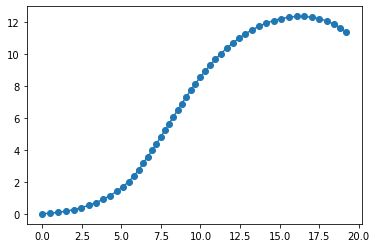

In [135]:
def ut_left_right_step(t, steer_v, total_t):
    sv = steer_v if t < total_t*0.3 else (-steer_v if t <= total_t else 0)
    return control_vector(steer_vel=sv)
    
total_t = 5.0
dt = 0.1
states = integ_state_ut(int(total_t/dt), state_vector(vel=5), 
                            ut_func=(lambda t: ut_left_right_step(t, 0.2, total_t)), dt=dt)
plot_traj(states)